In [160]:
import torch
import time
import numpy as np
import fastvol as fv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from tqdm import tqdm
from typing import Literal

import QuantLib as ql
from financepy.utils.global_types import OptionTypes
from financepy.models.equity_crr_tree import crr_tree_val

In [2]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.25
plt.rcParams["savefig.bbox"] = "tight"
mpl.rcParams['animation.embed_limit'] = 100  # in MB

markersize = 2

# QL - BS 2002

In [ ]:
def bs2002(
    spot: np.ndarray = 100.0, strike: np.ndarray=100.0, c_flag: np.ndarray = True, ttm: np.ndarray = 1.0, iv: np.ndarray = 0.2, rfr: np.ndarray = 0.05, div: np.ndarray=0.0):

    spot   = np.atleast_1d(spot).astype(float)
    strike = np.atleast_1d(strike).astype(float)
    ttm    = np.broadcast_to(np.atleast_1d(ttm), spot.shape).astype(float)
    iv     = np.atleast_1d(iv).astype(float)
    rfr    = np.atleast_1d(rfr).astype(float)
    div    = np.atleast_1d(div).astype(float)
    c_flag = np.broadcast_to(np.array(c_flag), spot.shape).astype(bool)
    
    res = np.empty_like(spot)
    
    calendar = ql.NullCalendar()
    day_count = ql.Actual365Fixed()
    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today

    for i in range(spot.shape[0]):
        
        expiry = today + int(ttm[i] * 365)
        exercise = ql.AmericanExercise(today, expiry)
        payoff = ql.PlainVanillaPayoff(ql.Option.Call if c_flag[i] else ql.Option.Put, strike[i])

        # Construct option
        option = ql.VanillaOption(payoff, exercise)

        # BS2002 engine
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot[i]))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, rfr[i], day_count))
        div_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, div[i], day_count))
        vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, iv[i], day_count))

        bsm_process = ql.BlackScholesMertonProcess(spot_handle, div_ts, flat_ts, vol_ts)

        engine = ql.BjerksundStenslandApproximationEngine(bsm_process)
        option.setPricingEngine(engine)

        # Output price
        res[i] = option.NPV()
        
    return res if res.shape[0] > 1 else res[0]


# Convergence

100%|██████████| 2048/2048 [00:01<00:00, 1041.73it/s]


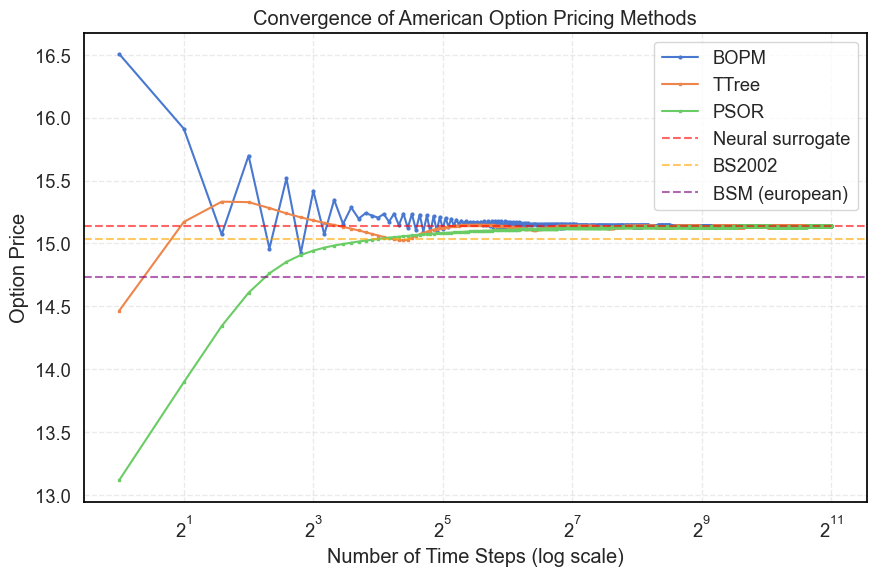

In [5]:
kwargs = dict(spot=90.0, strike=100.0, c_flag=False, ttm=0.5, iv=0.4, rfr=0.05, div=0.0)

n_steps = np.arange(2048) + 1 #np.unique(np.logspace(0, 12, num=200, base=2).astype(int))

price_bopm  = [fv.american.bopm.price_fp64(**kwargs, n_steps=s) for s in tqdm(n_steps)]
price_ttree = [fv.american.ttree.price_fp64(**kwargs, n_steps=s) for s in tqdm(n_steps)]
price_psor = [fv.american.psor.price_fp64(**kwargs, n_s=256, n_t=int(s), tol=1e-5) for s in tqdm(n_steps)]
price_bs2002 = bs2002(**kwargs)
price_neural = fv.american.neural.price_fp64(**kwargs)
price_bsm = fv.european.price_fp64(**kwargs)


plt.figure(figsize=(9, 6))
plt.plot(n_steps, price_bopm, marker='o', label="BOPM", markersize=markersize)
plt.plot(n_steps, price_ttree, marker='s', label="TTree", markersize=markersize)
plt.plot(n_steps, price_psor, marker='s', label="PSOR", markersize=markersize)

plt.axhline(price_neural, color='red', linestyle='--', alpha=0.6, label="Neural surrogate")
plt.axhline(price_bs2002, color='orange', linestyle='--', alpha=0.6, label="BS2002")
plt.axhline(price_bsm, color='purple', linestyle='--', alpha=0.6, label="BSM (european)")

plt.xscale("log", base=2)
plt.xlabel("Number of Time Steps (log scale)")
plt.ylabel("Option Price")
plt.title("Convergence of American Option Pricing Methods")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# NN vs BS2002

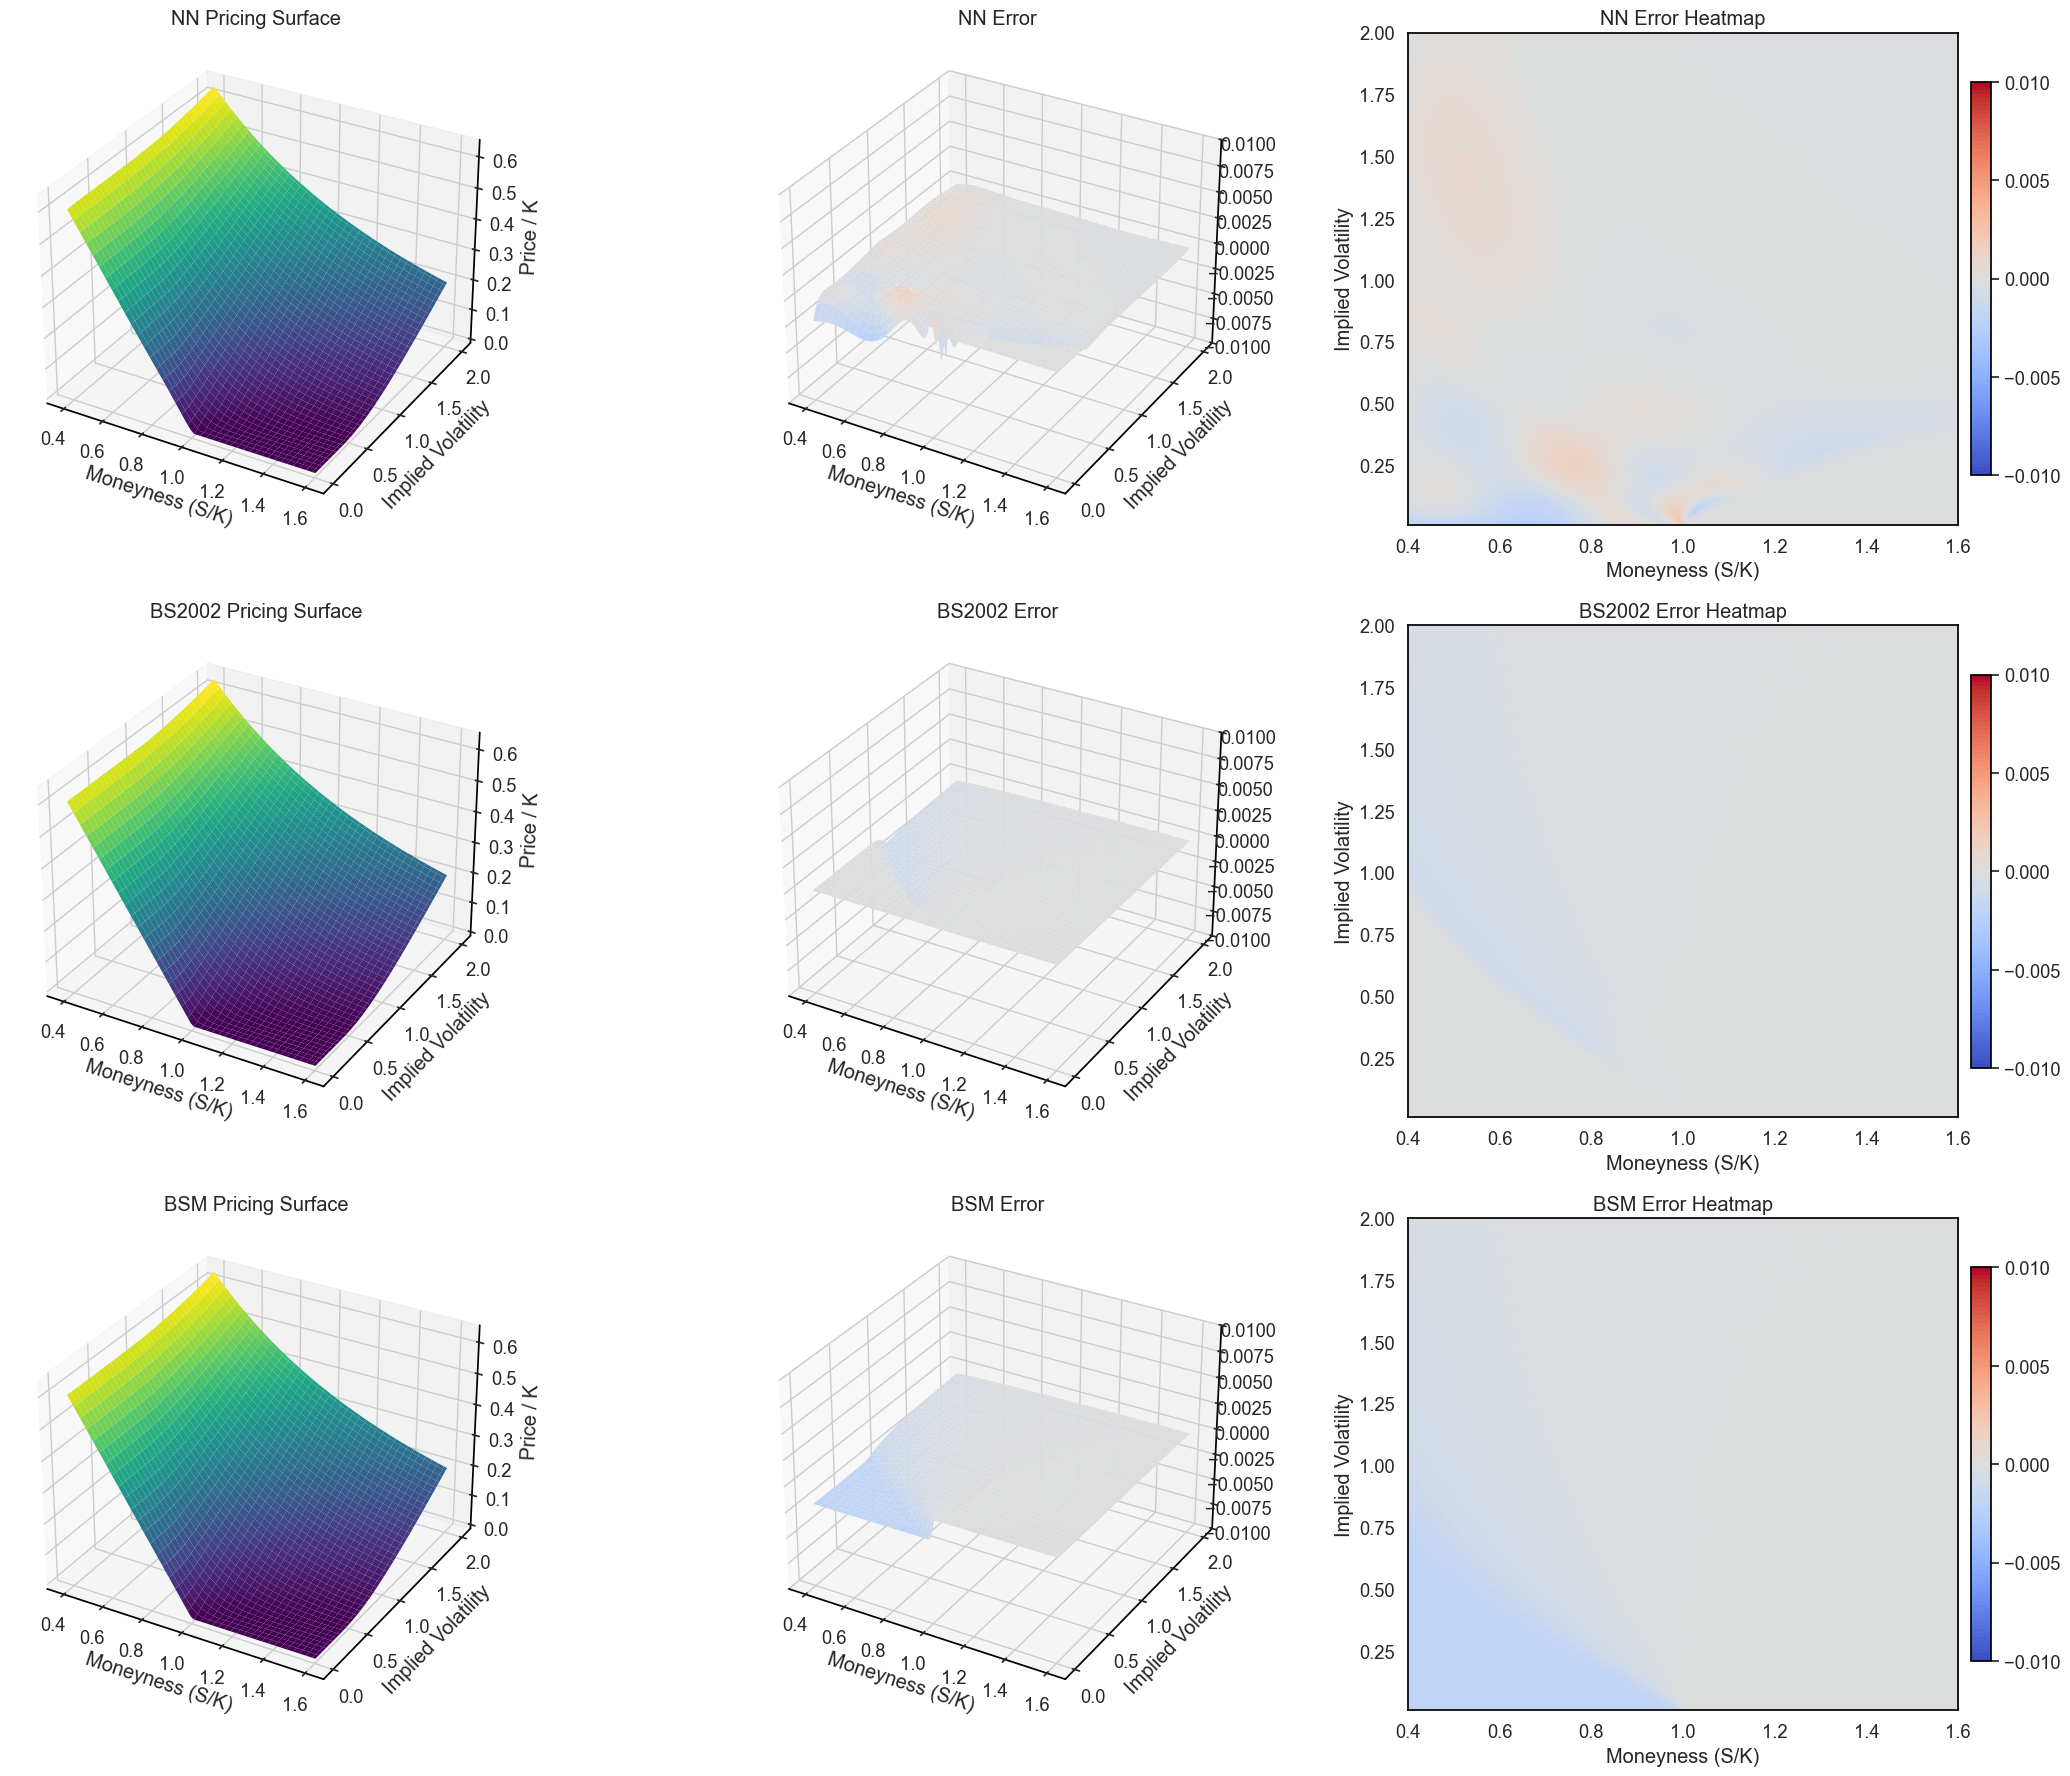

In [ ]:
c_flag = 0
ttm = 0.2

# grid setup
K_fixed = 100.0
S_vals = np.linspace(40, 160, 80, dtype=np.float64)      
iv_vals = np.linspace(0.01, 2.0, 80, dtype=np.float64)  

S_grid, iv_grid = np.meshgrid(S_vals, iv_vals)
S_batch = S_grid.ravel()
iv_batch = iv_grid.ravel()
K_batch = np.full_like(S_batch, K_fixed)

# params
cp_flag = np.full_like(S_batch, c_flag, dtype=np.uint8)  
ttm = np.full_like(S_batch, ttm, dtype=np.float64)
r   = np.full_like(S_batch, 0.01, dtype=np.float64)
q   = np.full_like(S_batch, 0.00, dtype=np.float64)

# normalized prices
Z_bopm  = fv.american.bopm.price_fp64_batch(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q, n_steps=2048) / K_fixed
Z_nn = fv.american.neural.price(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q, precision='fp64') / K_fixed
Z_bsm  = fv.european.bsm.price_fp64_batch(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q) / K_fixed
Z_bs2002 = bs2002(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q) / K_fixed

# reshape for surface plot
Z_nn = np.asarray(Z_nn.reshape(S_grid.shape))
Z_bopm = np.asarray(Z_bopm.reshape(S_grid.shape))
Z_bsm = np.asarray(Z_bsm.reshape(S_grid.shape))
Z_bs2002 = np.asarray(Z_bs2002.reshape(S_grid.shape))

# moneyness grid
sk_grid = S_grid / K_fixed

# errors
Z_nn_err = Z_nn - Z_bopm
Z_bsm_err = Z_bsm - Z_bopm
Z_bs2002_err = Z_bs2002 - Z_bopm


# axis min/max

# zmin = min(Z_nn_err.min(), Z_bsm_err.min(), Z_bs2002_err.min())
# zmax = max(Z_nn_err.max(), Z_bsm_err.max(), Z_bs2002_err.max())

zmax = 0.01# np.max(np.abs([Z_nn_err, Z_bsm_err, Z_bs2002_err]))
zmin = - zmax

vmin, vmax = zmin, zmax
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
levels = np.linspace(vmin, vmax, 100)

# plotting

fig = plt.figure(figsize=(22, 18))
def triple_plot(fig: plt.Figure, axs: list, plot_loc: int, name: str, Z: np.ndarray, Z_err: np.ndarray) -> None:
    
    # pricing surface
    axs.append(fig.add_subplot(plot_loc, projection='3d'))
    axs[-1].plot_surface(sk_grid, iv_grid, Z, cmap='viridis', edgecolor='none')
    axs[-1].set_title(f"{name} Pricing Surface")
    axs[-1].set_xlabel("Moneyness (S/K)")
    axs[-1].set_ylabel("Implied Volatility")
    axs[-1].set_zlabel("Price / K")

    # error surface
    axs.append(fig.add_subplot(plot_loc + 1, projection='3d'))
    axs[-1].plot_surface(sk_grid, iv_grid, Z_err, cmap='coolwarm', edgecolor='none', norm=norm)
    axs[-1].set_title(f"{name} Error")
    axs[-1].set_xlabel("Moneyness (S/K)")
    axs[-1].set_ylabel("Implied Volatility")
    # axs[-1].set_zlabel("Error")
    axs[-1].set_zlim(zmin, zmax)

    # extract the automatically chosen z-axis ticks so we can match the heatmap ticks
    plt.draw()
    ticks = axs[-1].get_zticks()

    # error heatmap
    axs.append(fig.add_subplot(plot_loc + 2))
    contour = axs[-1].contourf(sk_grid, iv_grid, Z_err, levels=levels, cmap='coolwarm', norm=norm)
    fig.colorbar(contour, ax=axs[-1], shrink=0.8, pad=0.02, ticks=ticks)
    axs[-1].set_title(f"{name} Error Heatmap")
    axs[-1].set_xlabel("Moneyness (S/K)")
    axs[-1].set_ylabel("Implied Volatility")
    

axs  = []
triple_plot(fig, axs, 331, 'NN', Z_nn, Z_nn_err)
triple_plot(fig, axs, 334, 'BS2002', Z_bs2002, Z_bs2002_err)
triple_plot(fig, axs, 337, 'BSM', Z_bsm, Z_bsm_err)


plt.tight_layout()
plt.show()



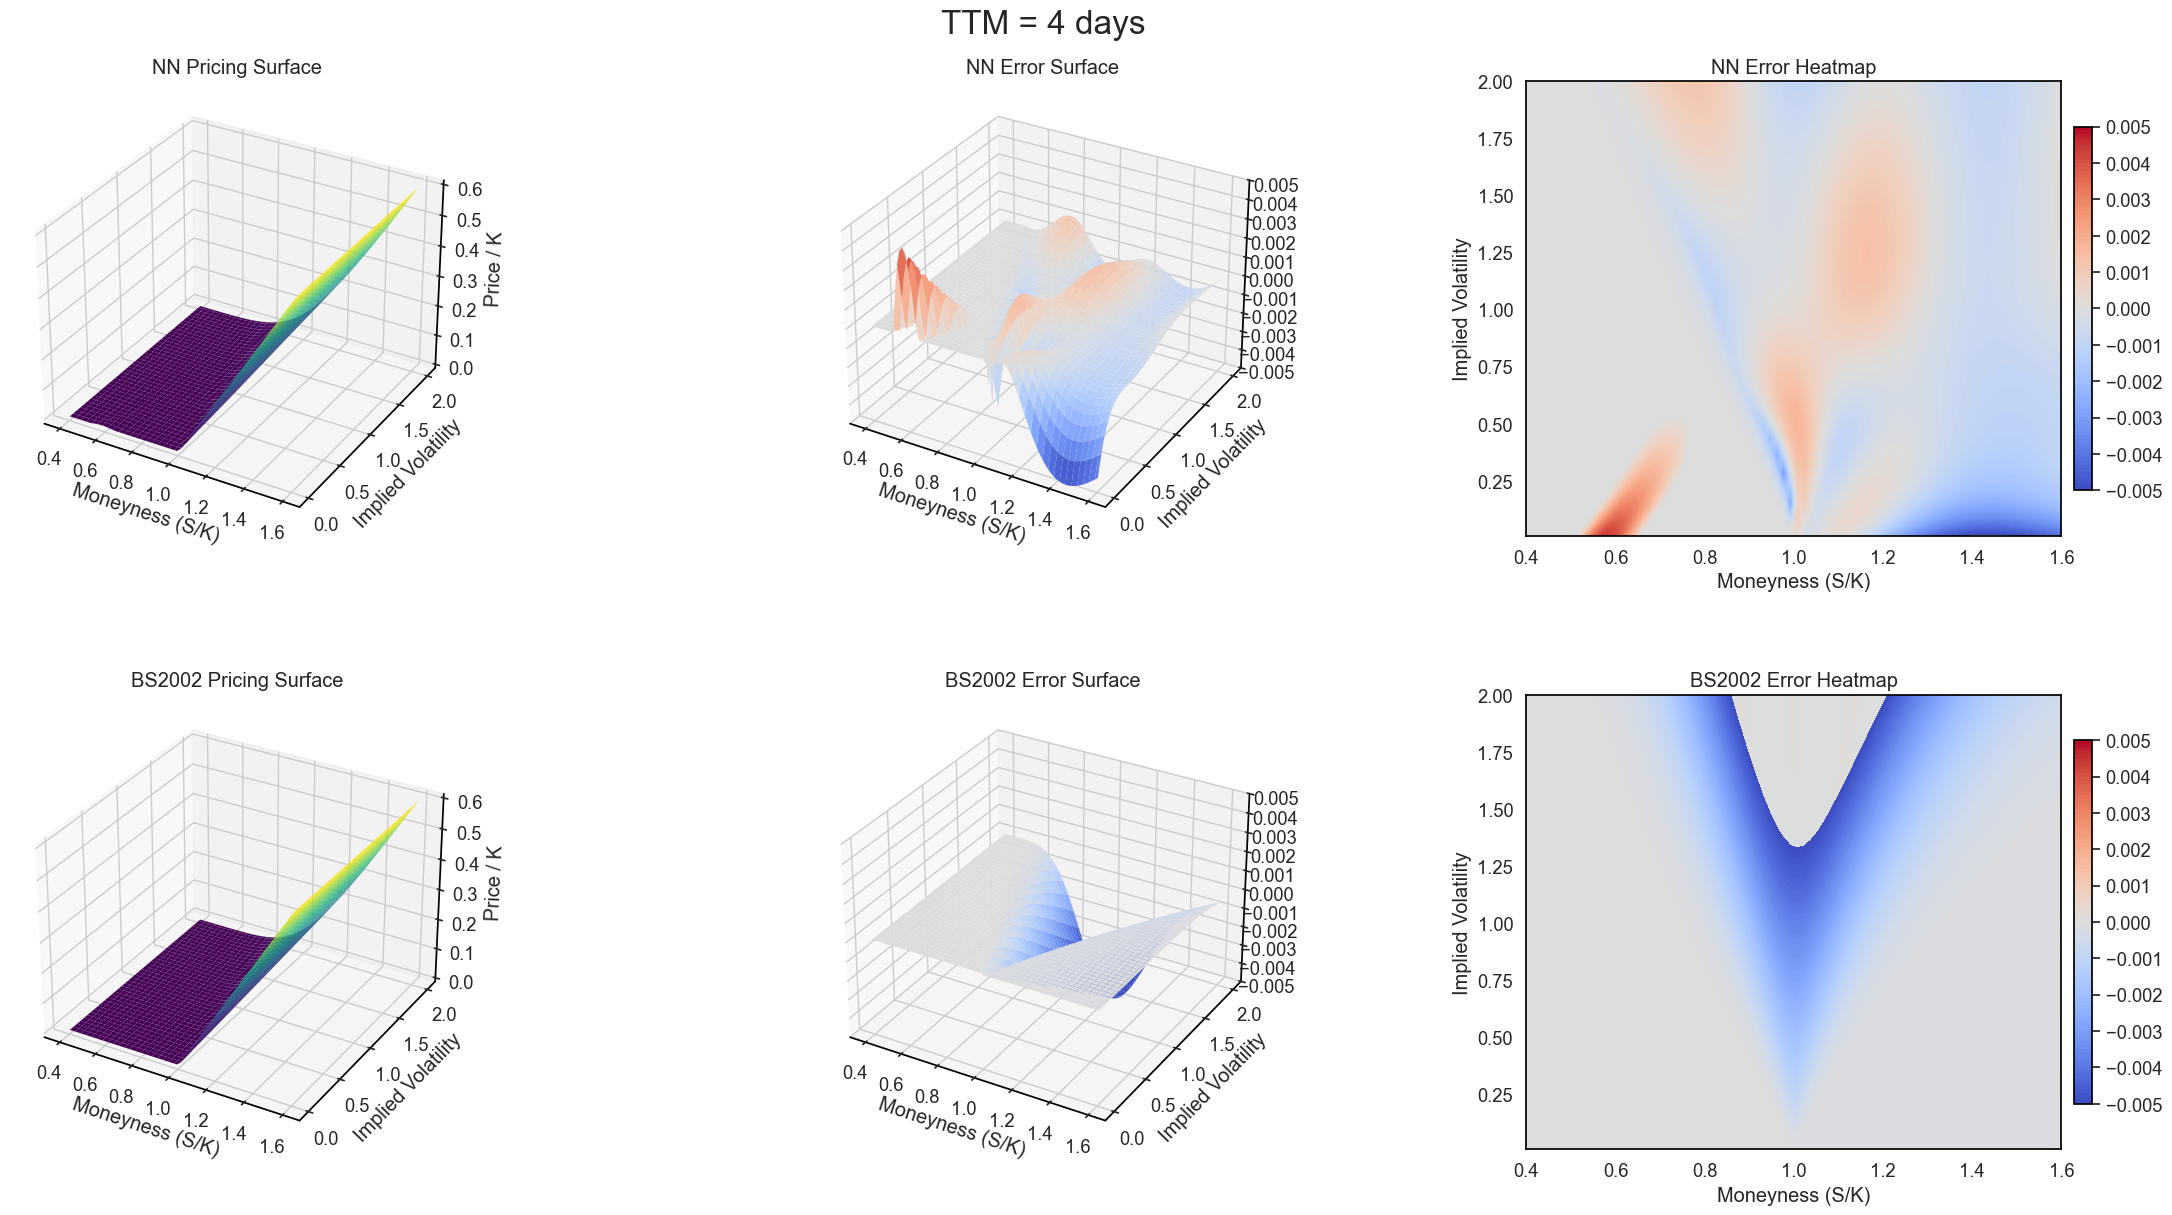

In [ ]:
# Setup
c_flag = 0
K_fixed = 100.0

vmax = 0.025 # 0.025 for puts
vmin = -vmax
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
levels = np.linspace(vmin, vmax, 100)
ticks = np.linspace(vmin, vmax, 11)

S_vals = np.linspace(40, 160, 80, dtype=np.float64)
iv_vals = np.linspace(0.01, 2.0, 80, dtype=np.float64)
S_grid, iv_grid = np.meshgrid(S_vals, iv_vals)
S_batch = S_grid.ravel()
iv_batch = iv_grid.ravel()
K_batch = np.full_like(S_batch, K_fixed)
cp_flag = np.full_like(S_batch, c_flag, dtype=np.uint8)
r = np.full_like(S_batch, 0.05, dtype=np.float64)
q = np.full_like(S_batch, 0.00, dtype=np.float64)
sk_grid = S_grid / K_fixed

# Animation range
ttm_vals = np.linspace(0.01, 2.0, 90)

# Init fig
fig = plt.figure(figsize=(24, 12))
axs = [fig.add_subplot(231, projection='3d'),
       fig.add_subplot(232, projection='3d'),
       fig.add_subplot(233),
       fig.add_subplot(234, projection='3d'),
       fig.add_subplot(235, projection='3d'),
       fig.add_subplot(236),
    #    fig.add_subplot(337, projection='3d'),
    #    fig.add_subplot(338, projection='3d'),
    #    fig.add_subplot(339)
       ]

# colorbar tracking
colorbars = [None] * 3

def compute_surfaces(ttm_val):
    ttm = np.full_like(S_batch, ttm_val)
    
    Z_bopm = fv.american.bopm.price_fp64_batch(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q, n_steps=2048) / K_fixed
    Z_nn = fv.american.neural.price(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q, precision='fp64') / K_fixed
    Z_bsm = fv.european.bsm.price_fp64_batch(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q) / K_fixed
    Z_bs2002 = bs2002(S_batch, K_batch, cp_flag, ttm, iv_batch, r, q) / K_fixed

    Z_bopm = np.asarray(Z_bopm.reshape(S_grid.shape))
    Z_nn = np.asarray(Z_nn.reshape(S_grid.shape))
    Z_bsm = np.asarray(Z_bsm.reshape(S_grid.shape))
    Z_bs2002 = np.asarray(Z_bs2002.reshape(S_grid.shape))

    Z_nn_err = Z_nn - Z_bopm
    Z_bsm_err = Z_bsm - Z_bopm
    Z_bs2002_err = Z_bs2002 - Z_bopm

    return (Z_nn, Z_nn_err, Z_bs2002, Z_bs2002_err, Z_bsm, Z_bsm_err)

def update(frame_idx):
    ttm_val = ttm_vals[frame_idx]
    fig.suptitle(f"TTM = {ttm_val*365.0:.0f} days", fontsize=24)

    Z_nn, Z_nn_err, Z_bs2002, Z_bs2002_err, Z_bsm, Z_bsm_err = compute_surfaces(ttm_val)

    surfaces = [
        (Z_nn, Z_nn_err, 'NN'),
        (Z_bs2002, Z_bs2002_err, 'BS2002'),
        # (Z_bsm, Z_bsm_err, 'BSM'),
    ]
    
    # vmax = np.max(np.abs([Z_nn_err, Z_bs2002_err]))
    # vmin = -vmax
    # norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    # levels = np.linspace(vmin, vmax, 100)
    # ticks = np.linspace(vmin, vmax, 11)

    for i, (Z, Z_err, name) in enumerate(surfaces):
        ax_price = axs[i * 3]
        ax_err3d = axs[i * 3 + 1]
        ax_heat = axs[i * 3 + 2]

        ax_price.clear()
        ax_price.plot_surface(sk_grid, iv_grid, Z, cmap='viridis', edgecolor='none')
        ax_price.set_title(f"{name} Pricing Surface")
        ax_price.set_xlabel("Moneyness (S/K)")
        ax_price.set_ylabel("Implied Volatility")
        ax_price.set_zlabel("Price / K")

        ax_err3d.clear()
        ax_err3d.plot_surface(sk_grid, iv_grid, Z_err, cmap='coolwarm', edgecolor='none', norm=norm)
        ax_err3d.set_title(f"{name} Error Surface")
        ax_err3d.set_xlabel("Moneyness (S/K)")
        ax_err3d.set_ylabel("Implied Volatility")
        ax_err3d.set_zlim(vmin, vmax)
        ax_err3d.set_zticks(ticks)
        
        
        if colorbars[i] is not None:
            colorbars[i].remove()

        contour = ax_heat.contourf(sk_grid, iv_grid, Z_err, levels=levels, cmap='coolwarm', norm=norm)
        colorbars[i] = fig.colorbar(contour, ax=ax_heat, shrink=0.8, pad=0.02, ticks=ticks)
        ax_heat.set_title(f"{name} Error Heatmap")
        ax_heat.set_xlabel("Moneyness (S/K)")
        ax_heat.set_ylabel("Implied Volatility")

    fig.subplots_adjust(left=0.03, right=0.97, bottom=0.03, top=0.92, wspace=0.25, hspace=0.35)

ani = FuncAnimation(fig, update, frames=len(ttm_vals), interval=250, repeat=True)

writer = FFMpegWriter(fps=10, metadata=dict(artist='Valerio Galanti'), bitrate=1800)
ani.save("animation.mp4", writer=writer)

In [235]:
ani.save("animation.gif", writer="pillow", fps=10)

# Throughput Benchmarks

In [4]:
# Common option parameters
n = 100_000
spot = np.full(n, 100.0)
strike = np.full(n, 100.0)
c_flag = np.random.randint(0, 2, size=n).astype(np.uint8)
ttm = np.full(n, 0.5)
iv = np.full(n, 0.2)
rfr = np.full(n, 0.05)
div = np.full(n, 0.00)

def format_ops_per_sec(k, elapsed_sec):
    ops_per_sec = k / elapsed_sec
    if ops_per_sec >= 1e6:
        return f"{ops_per_sec / 1e6:.2f}M ops/sec"
    elif ops_per_sec >= 1e3:
        return f"{ops_per_sec / 1e3:.2f}K ops/sec"
    else:
        return f"{ops_per_sec:.0f} ops/sec"

def format_ns_per_op(k, elapsed_sec):
    ns_per_op = (elapsed_sec / k) * 1e9
    if ns_per_op >= 1e6:
        return f"{ns_per_op / 1e6:.2f} ms/option"
    elif ns_per_op >= 1e3:
        return f"{ns_per_op / 1e3:.2f} us/option"
    else:
        return f"{ns_per_op:.1f} ns/option"

def print_perf(label, elapsed_sec, n):
    ops_str = format_ops_per_sec(n, elapsed_sec)
    ns_str = format_ns_per_op(n, elapsed_sec)
    print(f"{label:<30} {ops_str:>15}   ({ns_str:>15})")


def timeit(label: str, func, *args, k=100):
    times = []
    for i in range(k):
        start = time.perf_counter()
        func(spot[i], strike[i], c_flag[i], ttm[i], iv[i], rfr[i], div[i], *args)
        times.append(time.perf_counter() - start)
        
    print_perf(f"{label} {args}", sum(times), k)
    return min(times), times

In [5]:
def ql_bopm(spot, strike, c_flag, ttm, iv, rfr, div, n_steps):
    calendar = ql.NullCalendar()
    day_count = ql.Actual365Fixed()
    today = ql.Date.todaysDate()
    maturity = today + int(ttm * 365.0)

    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, rfr, day_count))
    div_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, div, day_count))
    vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today, calendar, iv, day_count)
    )

    ql_option_type = ql.Option.Call if c_flag else ql.Option.Put
    payoff = ql.PlainVanillaPayoff(ql_option_type, strike)
    exercise = ql.AmericanExercise(today, maturity)
    
    option = ql.VanillaOption(payoff, exercise)

    bsm_process = ql.BlackScholesMertonProcess(spot_handle, div_ts, flat_ts, vol_ts)
    engine = ql.BinomialVanillaEngine(bsm_process, 'crr', n_steps)
    option.setPricingEngine(engine)

    return option.NPV()

In [ ]:
def fp_bopm(spot, strike, c_flag, ttm, iv, rfr, div, n_steps):
    o = OptionTypes.AMERICAN_CALL.value if c_flag else OptionTypes.AMERICAN_PUT.value
    n_steps = n_steps / ttm # internally fp does step rescaling
    
    return crr_tree_val(
        spot, rfr, div, iv, n_steps, ttm, o, strike, True
    )[0]
    

In [ ]:
times = timeit('QL-BOPM', ql_bopm, 256, k=1000)
times = timeit('QL-BOPM', ql_bopm, 512, k=1000)
times = timeit('QL-BOPM', ql_bopm, 1024, k=500)
times = timeit('QL-BOPM', ql_bopm, 2048, k=500)
times = timeit('QL-BOPM', ql_bopm, 4096, k=300)
print()

times = timeit('FP-BOPM', fp_bopm, 256, k=1000)
times = timeit('FP-BOPM', fp_bopm, 512, k=1000)
times = timeit('FP-BOPM', fp_bopm, 1024, k=300)
times = timeit('FP-BOPM', fp_bopm, 2048, k=300)
times = timeit('FP-BOPM', fp_bopm, 4096, k=200)
print()

times = timeit('FV-BOPM', fv.american.bopm.price_fp64, 256, k=1000)
times = timeit('FV-BOPM', fv.american.bopm.price_fp64, 512, k=1000)
times = timeit('FV-BOPM', fv.american.bopm.price_fp64, 2048, k=500)
times = timeit('FV-BOPM', fv.american.bopm.price_fp64, 2048, k=500)
times = timeit('FV-BOPM', fv.american.bopm.price_fp64, 4096, k=500)

QL-BOPM (256,)                   3.87K ops/sec   (258.52 us/option)
QL-BOPM (512,)                   1.31K ops/sec   (762.00 us/option)
QL-BOPM (1024,)                    350 ops/sec   ( 2.86 ms/option)
QL-BOPM (2048,)                     94 ops/sec   (10.66 ms/option)
QL-BOPM (4096,)                     24 ops/sec   (42.48 ms/option)
FP-BOPM (256,)                   2.69K ops/sec   (371.45 us/option)
FP-BOPM (512,)                     477 ops/sec   ( 2.10 ms/option)
FP-BOPM (1024,)                    128 ops/sec   ( 7.82 ms/option)
FP-BOPM (2048,)                     27 ops/sec   (37.37 ms/option)
FP-BOPM (4096,)                      7 ops/sec   (147.79 ms/option)
FV-BOPM (256,)                 115.98K ops/sec   ( 8.62 us/option)
FV-BOPM (512,)                  35.54K ops/sec   (28.14 us/option)
FV-BOPM (2048,)                  2.35K ops/sec   (426.38 us/option)
FV-BOPM (2048,)                  2.58K ops/sec   (388.09 us/option)
FV-BOPM (4096,)                    679 ops/sec   ( 1.47 

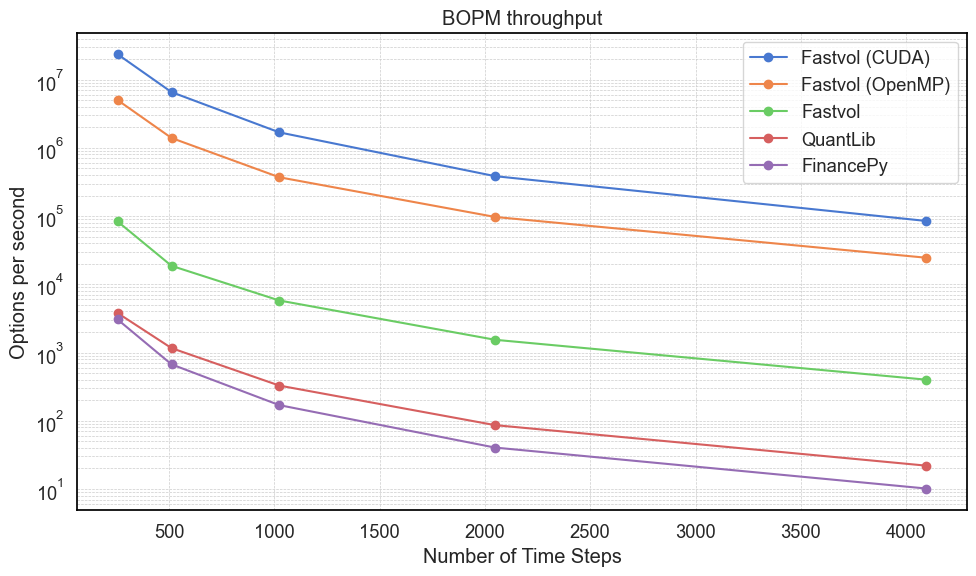

In [8]:
## numbers ran on GH200 -- where CUDA is enabled -- for fair comparison
methods = [
    "Fastvol (CUDA)",
    "Fastvol (OpenMP)",
    "Fastvol",
    "QuantLib",
    "FinancePy",
]

steps = [256, 512, 1024, 2048, 4096]

timings_ns = np.array([
    [42.5,       152.5,       593.6,      2_600.0,    11_800.0], # Fastvol CUDA 
    [199.7,      717.3,       2700.0,     10_300.0,   40_800.0], # Fastvol CPU batch
    [12_000,     53_600,     172_700,    650_200,   2_500_000],  # Fastvol CPU scalar
    [263_680,    861_620,   3_050_000, 11_580_000, 45_470_000],  # QL
    [327_810,  1_490_000,   5_900_000, 24_700_000, 98_400_000],  # FP
])
opts_p_sec = (1e9 / timings_ns)

fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    ax.plot(steps, opts_p_sec[i], marker='o', label=method)

# ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Number of Time Steps")
ax.set_ylabel("Options per second")
ax.set_title("BOPM throughput")
ax.grid(True, which="both", ls="--", lw=0.5)
ax.legend()
plt.tight_layout()
plt.show()



# PDE

## impls

Simplified equivalent python implementations for debugging/iteration count tracking

In [138]:
def rb_psor(aa, bb, cc, V, init, payoff, w, tol2, max_iter):
    
    n = len(V)
    x = init.copy()
    x_old = x.copy()
    
    for it in range(max_iter):
    
        # bottom value
        res = V[0] - cc * x[1]
        new = (1 - w) * x[0] + w * res / bb
        x[0] = max(new, payoff[0])
        
        # middle, more SIMD/interleaving friendly
        for i in range(2, n-1, 2):
            res = V[i] - aa * x[i - 1] - cc * x[i + 1]
            new = (1 - w) * x[i] + w * res / bb
            x[i] = max(new, payoff[i]) # projection
            
        # top value, first red or last black
        res = V[n-1] - aa * x[n-2]
        new = (1 - w) * x[n-1] + w * res / bb
        x[n-1] = max(new, payoff[n-1])
            
        # middle, more SIMD/interleaving friendly
        for i in range(1, n-1, 2):
            res = V[i] - aa * x[i - 1] - cc * x[i + 1]
            new = (1 - w) * x[i] + w * res / bb
            x[i] = max(new, payoff[i]) # projection

        sqdist = 0.0
        for i in range(n):
            sqdist += (x[i] - x_old[i])**2
        
        if sqdist / n < tol2:
            # print("converged at", it, "err =", sqdist)
            return x, it
        
        x_old = x.copy()
        
    return x, it

def psor(aa, bb, cc, V, init, payoff, w, tol2, max_iter):
    
    n = len(V)
    x = init.copy()
    x_old = x.copy()
    
    for it in range(max_iter):
    
        # bottom value
        res = V[0] - cc * x[1]
        new = (1 - w) * x[0] + w * res / bb
        x[0] = max(new, payoff[0])
        
        # middle, more SIMD/interleaving friendly
        for i in range(1, n-1):
            res = V[i] - aa * x[i - 1] - cc * x[i + 1]
            new = (1 - w) * x[i] + w * res / bb
            x[i] = max(new, payoff[i]) # projection
        
        # top value
        res = V[n-1] - aa * x[n-2]
        new = (1 - w) * x[n-1] + w * res / bb
        x[n-1] = max(new, payoff[n-1])

        sqdist = 0.0
        for i in range(n):
            sqdist += (x[i] - x_old[i])**2
        
        if sqdist / n < tol2:
            # print("converged at", it, "err =", sqdist)
            return x, it
        
        x_old = x.copy()
        
    return x, it

def gs(aa, bb, cc, V, init, payoff, tol2, max_iter):
    return psor(aa, bb, cc, V, init, payoff, 1.0, tol2, max_iter)


def jacobi(aa, bb, cc, V, init, payoff, w, tol2, max_iter):
    
    n = len(V)
    x = init.copy()
    x_old = x.copy()
    
    for it in range(max_iter):
    
        # bottom value
        res = V[0] - cc * x_old[1]
        new = (1 - w) * x_old[0] + w * res / bb
        x[0] = max(new, payoff[0])
        
        # middle, more SIMD/interleaving friendly
        for i in range(1, n-1):
            res = V[i] - aa * x_old[i - 1] - cc * x_old[i + 1]
            new = (1 - w) * x_old[i] + w * res / bb
            x[i] = max(new, payoff[i]) # projection
        
        # top value
        res = V[n-1] - aa * x_old[n-2]
        new = (1 - w) * x_old[n-1] + w * res / bb
        x[n-1] = max(new, payoff[n-1])

        sqdist = 0.0
        for i in range(n):
            sqdist += (x[i] - x_old[i])**2
        
        if sqdist / n < tol2:
            # print(f"converged on it: {it}")
            return x, it
        
        x_old = x.copy()
        
    return x, it
    


def pde_price(
    S=100.0, K=100.0, c_flag=True, ttm=1.0, iv=0.2, r=0.05, q=0.0, 
    w=1.1, n_s=256, n_t=1024, tol=1e-4, max_iter=1_000, 
    solver:Literal['psor', 'jacobi', 'rb_psor'] = 'rb_psor', 
    init_with: Literal['payoff', 'last_v'] = 'payoff', 
    smart_w_start: bool = False,
    adaptive_w: bool = False
    ):
    
    # n: number of interior points
    n = n_s - 2
    
    S_min, S_max = K / 3, 3 * K
    x_min, x_max = np.log(S_min), np.log(S_max)
    
    dx = (x_max - x_min) / (n_s - 1)
    dt = ttm / n_t
    
    iv2 = iv**2
    dx2 = dx * dx

    # Tridiagonal coefficients (constant)
    aa =  0.5 * dt * ((r - q - 0.5 * iv2) / dx - iv2 / dx2)
    bb =  1 + dt * (iv2 / dx2 + r)
    cc = -0.5 * dt * ((r - q - 0.5 * iv2) / dx + iv2 / dx2)
    
    
    if adaptive_w:
        
        if smart_w_start:
            rho = np.abs((aa + cc) / bb) * np.cos(np.pi / (n + 1))
            w = 2.0 / (1.0 + np.sqrt(1.0 - rho * rho))
        
            w_lo = max(0.7, w - 0.3);
            w_hi = min(1.9, w + 0.3);
        
        else:
            w_lo = min(0.7, w)
            w_hi = max(2.0, w)
        
        w_delta = (w_hi - w_lo) / 10 # delta to modify the next w by 
        prev_it = max_iter # previous delta's iterations
        ws = []

    # price grid
    S_grid = np.empty(n_s)
    for i in range(n_s):
        S_grid[i] = np.exp(x_min + i*dx)
        
    # pre-compute boundary corrections
    corrections = np.empty(n_t)
    cf = cc if c_flag else aa # correction factor
    ci = n_s - 3 if c_flag else 0 # correction index
    
    s = S_max if c_flag else -S_min
    k = -K if c_flag else K
    
    # backtrack is from 1 to n_t (inclusive)
    for i in range(n_t):
        tau = (i+1) * dt
        euro = s * np.exp(-q * tau) + k * np.exp(-r * tau)
        exercised = s + k
        corrections[i] = cf*max(euro, exercised)
        
    
    # Initial condition: payoff at maturity
    payoff = np.empty(n)
    if c_flag:
        for i in range(n):
            payoff[i] = max(S_grid[i+1] - K, 0)
    else:
        for i in range(n):
            payoff[i] = max(K - S_grid[i+1], 0)
    
    # terminal v
    V = payoff.copy()
    tol2 = tol*tol
    
    iters = []
    
    grid = np.empty((n_t+1, n))
    grid[-1] = payoff.copy()
    
    # backtrack
    for i in tqdm(range(n_t)):
        
        # boundary corrections
        V[ci] -= corrections[i]

        init = payoff if init_with == 'payoff' else V
        
        if solver == 'psor':
            V, it = psor(aa, bb, cc, V, init, payoff, w, tol2, max_iter)
        elif solver == 'rb_psor':
            V, it = rb_psor(aa, bb, cc, V, init, payoff, w, tol2, max_iter)
        else:
            V, it = jacobi(aa, bb, cc, V, init, payoff, w, tol2, max_iter)
        
        grid[n_t - 1 -i] = V.copy()
        
        if adaptive_w:
                        
            if i == 0:
                pass
                
            if i < 400:
                if it > prev_it: 
                    # if next w check (backwards) yields a lower value, set this as a boundary
                    w_delta = -w_delta # flip directions
                    
                elif it < prev_it:
                    
                    if w_delta < 0: # the new boundary is the hi boundary
                        w_hi = w-w_delta
                    else:  # boundary to confirm was the lo
                        w_lo = w-w_delta
        
                    w_delta = np.sign(w_delta) * (w_hi - w_lo) / 10 # update w_delta step size
            
                # if w_delta < 0.02: # turn off after a certain threshold
                #     adaptive_w = False 
                w = min(max(w+w_delta, w_lo), w_hi)
            
            prev_it = it
            ws.append(w)
        
            
        iters.append(it)
    
    # interpolation
    # NOTE: linearly interpolates beyond bounds
    # far OTM -> value delta gamma 0 so reasonable
    # far ITM -> delta 1 gamma 0 so can continue linear interp
    idx_hi = int((np.log(S) - x_min)/dx)
    idx_hi = min(max(idx_hi, 0), n-2)
    idx_lo = idx_hi - 1
    
        
    logx = x_min + (idx_lo + 1)*dx
    x0 = np.exp(logx)
    x1 = np.exp(logx + dx)
    
    gamma = (S - x0) / (x1 - x0)
    interp = (1.0 - gamma) * V[idx_lo] + gamma * V[idx_hi]
    
    if adaptive_w:
        return max(interp, 0.0), iters, ws 
    else:
        return max(interp, 0.0), iters


In [11]:
def plot_iterations_vs_timesteps(data_dict, title='Convergence Iterations vs Timestep'):
    plt.figure(figsize=(10, 6))
    
    for w_value, iterations_list in data_dict.items():
        timesteps = range(len(iterations_list))
        label = f'w={w_value}'
        plt.plot(timesteps, iterations_list, label=label, linewidth=2)
        
    plt.legend(
        bbox_to_anchor=(1.05, 1),  # place legend outside plot
        loc='upper left',
        borderaxespad=0.,
        fontsize='small'
    )

    plt.xlabel('Backtrack Timestep')
    plt.ylabel('Iterations to Converge')
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # plt.show()


## payoff vs last_v init

In [8]:
n_s, n_t = 256, 1024
iv = 0.9
ttm = 1.0
tol=1e-4

payoff_start = {}
for w in np.linspace(0.8, 1.7, 10):
    V, iters = pde_price(iv=iv, ttm=ttm, tol=tol, n_s=n_s, n_t=n_t, w=w, solver='rb_psor', init_with='payoff', max_iter=200)
    payoff_start[round(w,2)] = iters

v_start = {}
for w in np.linspace(0.8, 1.7, 10):
    V, iters = pde_price(iv=iv, ttm=ttm, tol=tol, n_s=n_s, n_t=n_t, w=w, solver='rb_psor', init_with='last_v', max_iter=200)
    v_start[round(w,2)] = iters

100%|██████████| 1024/1024 [00:06<00:00, 166.11it/s]


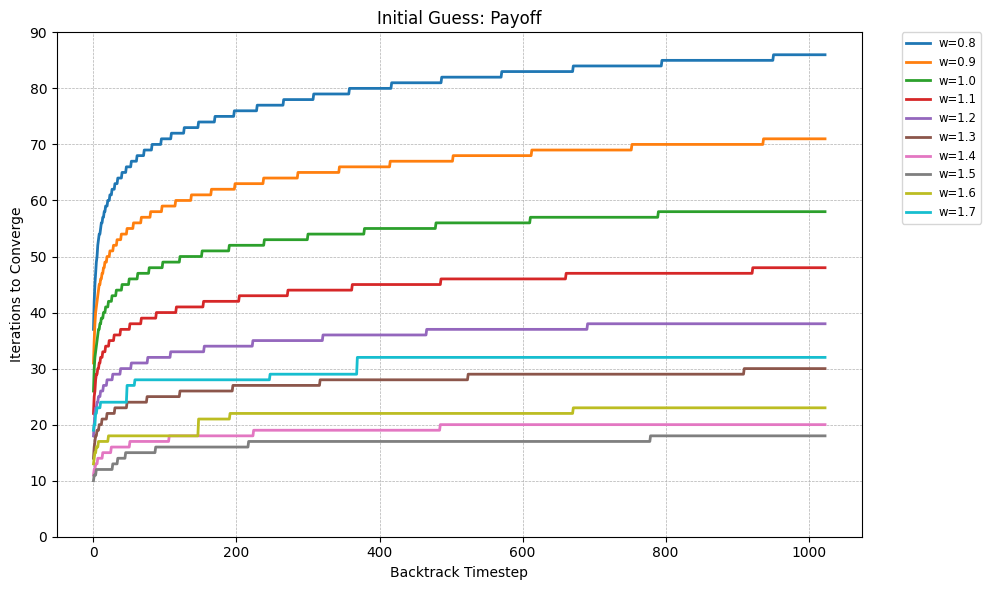

In [14]:
plot_iterations_vs_timesteps(payoff_start, "Initial Guess: Payoff")
plt.ylim(0, 90)
plt.show()

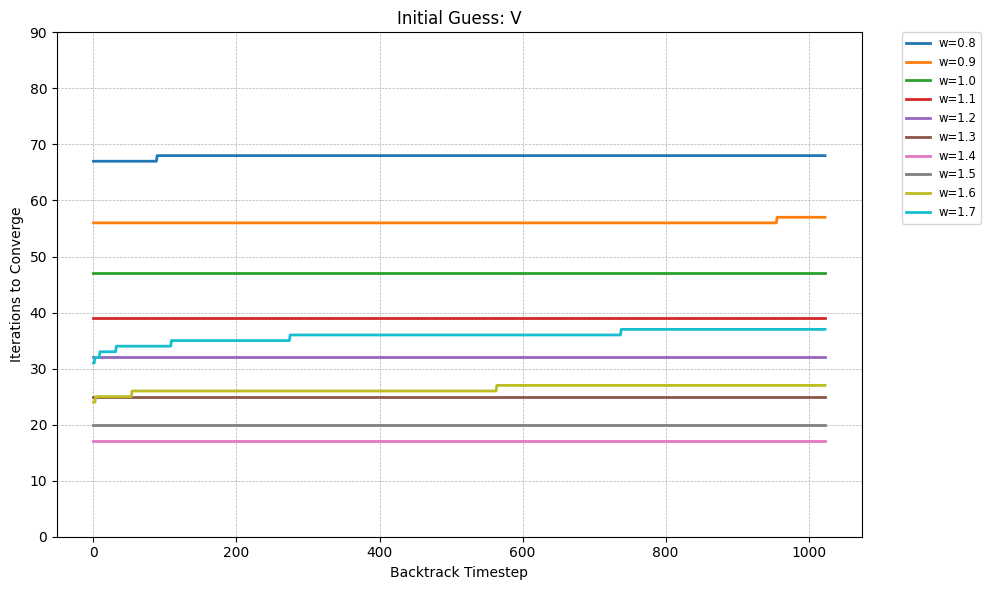

In [17]:
plot_iterations_vs_timesteps(v_start, "Initial Guess: V")
plt.ylim(0, 90)
plt.show()

## adaptive w

100%|██████████| 1024/1024 [00:02<00:00, 405.70it/s]


(0.0, 256.0)

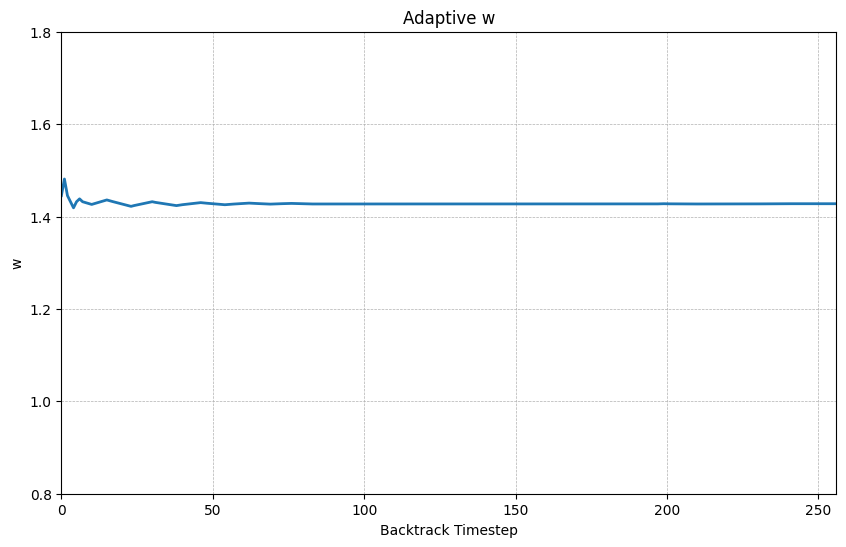

In [128]:
p, _, ws = pde_price(iv=0.5, w=0.5, ttm=3.0, n_s=256, n_t=1024, smart_w_start=True, adaptive_w=True)

plt.figure(figsize=(10, 6))
timesteps = range(len(ws))
plt.plot(timesteps, ws, linewidth=2)
plt.xlabel('Backtrack Timestep')
plt.ylabel('w')
plt.title("Adaptive w")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.8, 1.8)
plt.xlim(0, n_t/4)

100%|██████████| 1024/1024 [00:02<00:00, 403.36it/s]


(0.0, 256.0)

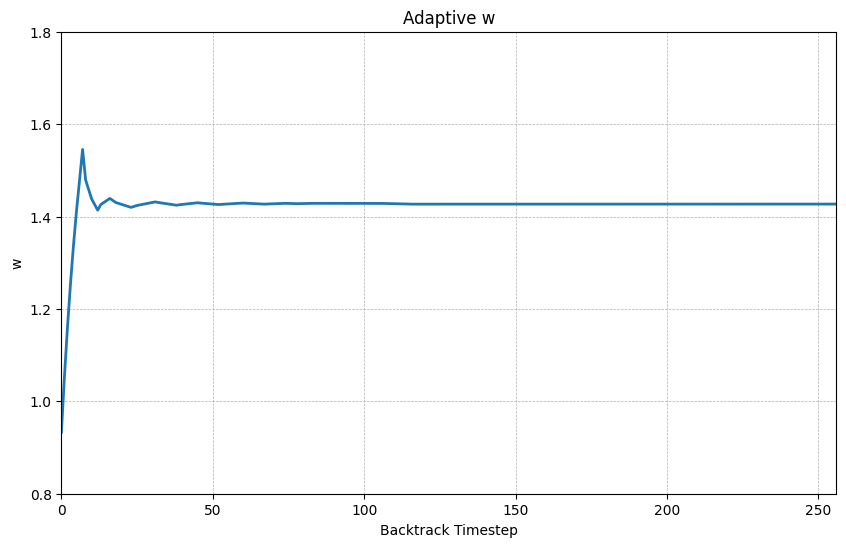

In [130]:
p, _, ws = pde_price(iv=0.5, w=0.8, ttm=3.0, n_s=256, n_t=1024, smart_w_start=False, adaptive_w=True)

plt.figure(figsize=(10, 6))
timesteps = range(len(ws))
plt.plot(timesteps, ws, linewidth=2)
plt.xlabel('Backtrack Timestep')
plt.ylabel('w')
plt.title("Adaptive w")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.8, 1.8)
plt.xlim(0, n_t/4)

## jacobi vs psor vs rb

In [148]:
np.linspace(0.8, 1.7, 7)

array([0.8 , 0.95, 1.1 , 1.25, 1.4 , 1.55, 1.7 ])

In [156]:
n_s, n_t = 256, 1024
iv = 0.5
ttm = 1.0
tol=1e-4

jacobi_ = {}
for w in np.linspace(0.8, 1.7, 7):
    V, iters = pde_price(iv=iv, ttm=ttm, tol=tol, n_s=n_s, n_t=n_t, w=w, solver='jacobi', init_with='payoff', max_iter=500)
    jacobi_[round(w,2)] = iters

psor_ = {}
for w in np.linspace(0.8, 1.7, 7):
    V, iters = pde_price(iv=iv, ttm=ttm, tol=tol, n_s=n_s, n_t=n_t, w=w, solver='psor', init_with='payoff', max_iter=500)
    psor_[round(w,2)] = iters
    
rb_psor_ = {}
for w in np.linspace(0.8, 1.7, 7):
    V, iters = pde_price(iv=iv, ttm=ttm, tol=tol, n_s=n_s, n_t=n_t, w=w, solver='rb_psor', init_with='payoff', max_iter=500)
    rb_psor_[round(w,2)] = iters


 28%|██▊       | 288/1024 [00:23<01:00, 12.13it/s]/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_2746/3464597093.py:109: RuntimeWarning: overflow encountered in scalar add
  sqdist += (x[i] - x_old[i])**2
 28%|██▊       | 290/1024 [00:23<01:00, 12.12it/s]/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_2746/3464597093.py:109: RuntimeWarning: overflow encountered in scalar power
  sqdist += (x[i] - x_old[i])**2
 56%|█████▋    | 577/1024 [01:10<01:12,  6.16it/s]/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_2746/3464597093.py:99: RuntimeWarning: overflow encountered in scalar multiply
  new = (1 - w) * x_old[i] + w * res / bb
/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_2746/3464597093.py:99: RuntimeWarning: invalid value encountered in scalar add
  new = (1 - w) * x_old[i] + w * res / bb
/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_2746/3464597093.py:104: RuntimeWarning: invalid value encountered in scalar add
  new = (1 - w)

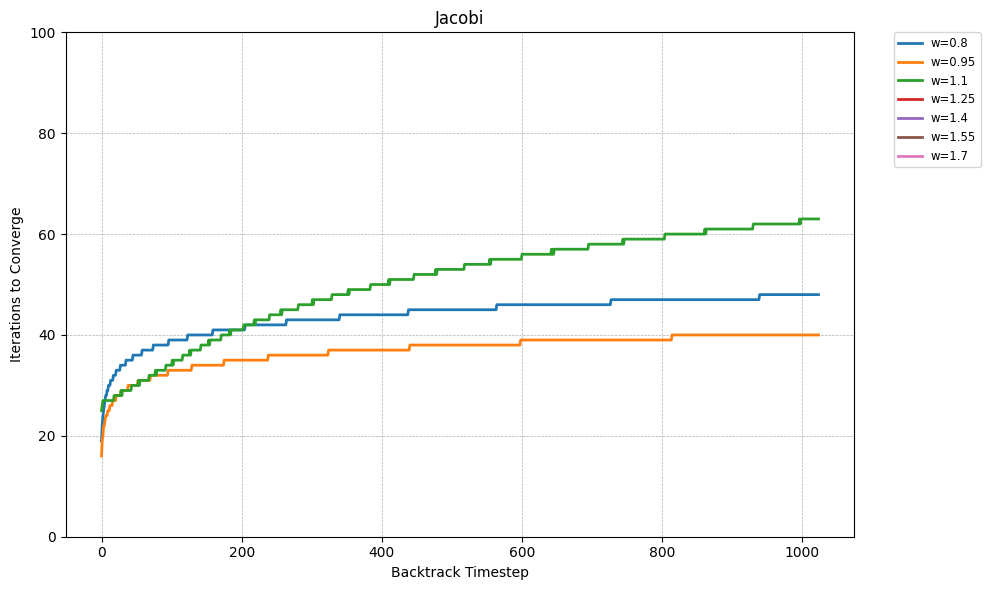

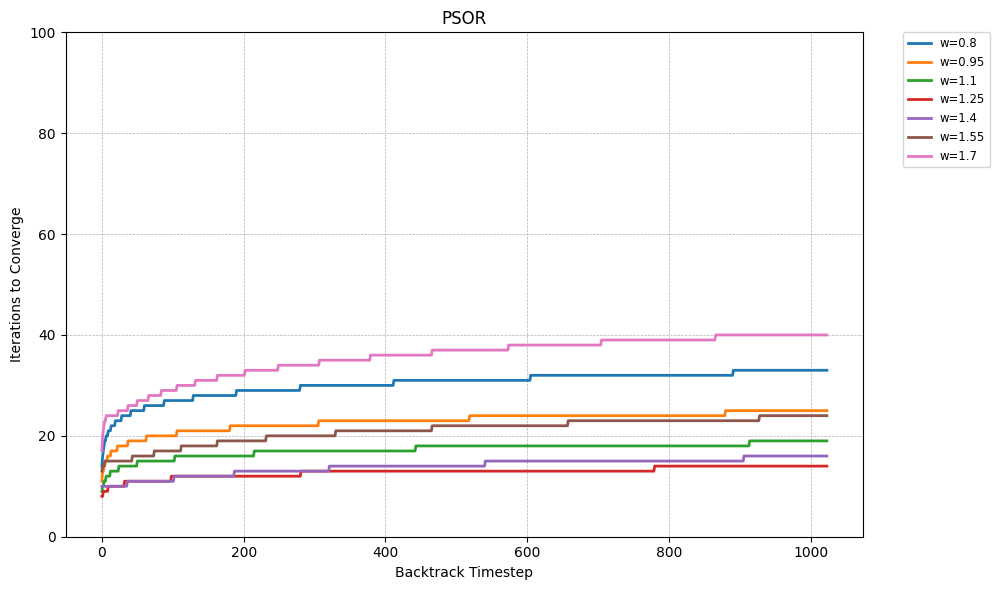

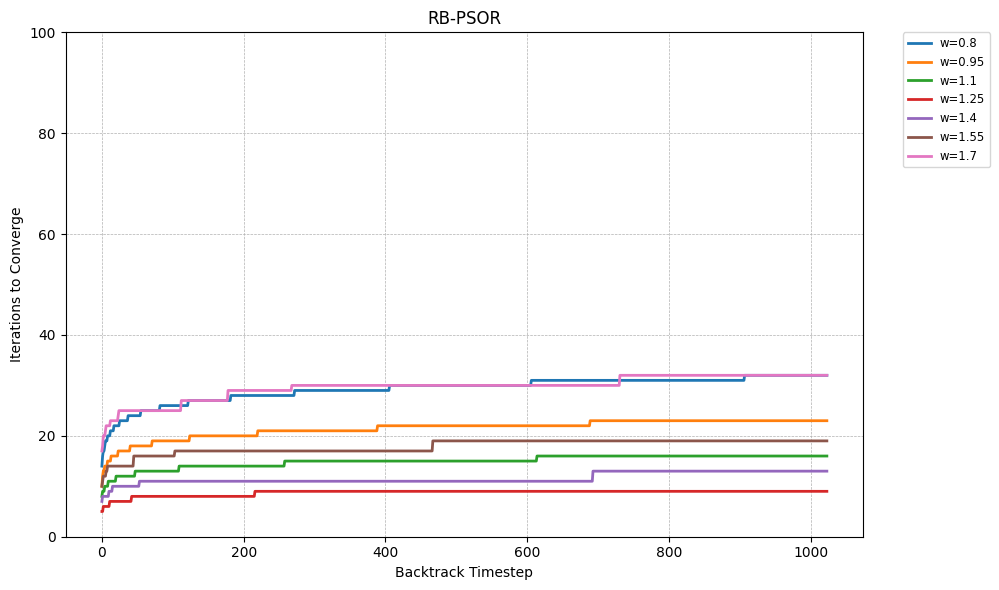

In [159]:
plot_iterations_vs_timesteps(jacobi_, "Jacobi")
plt.ylim(0, 100)
plt.show()

plot_iterations_vs_timesteps(psor_, "PSOR")
plt.ylim(0, 100)
plt.show()

plot_iterations_vs_timesteps(rb_psor_, "RB-PSOR")
plt.ylim(0, 100)
plt.show()